In [5]:

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.models import Model
import cv2
from cv2 import UMat
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import preprocess_input
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf

import numpy as np
import imutils
import cv2

In [2]:
model = tf.keras.models.load_model('D:/MAJOR P/t1.hdf5')

In [48]:
from PIL import Image
image_path = 'D:/SDT/test/c-spine_dis/GWARA_1.2.156.112536.2.560.144226186176121069.1318463587854. (19th copy).JPG'
input_size = (224, 224)  # Adjust the target size to match your model's input shape
image = Image.open(image_path).convert("RGB")
image = image.resize(input_size, Image.LANCZOS)
image = img_to_array(image)
image = preprocess_input(image)

image = np.expand_dims(image, axis=0)

In [7]:
class_labels = ['D', 'F', 'N']


In [34]:
class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName

        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output.shape) == 4:
                return layer.name

        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")

    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(inputs=[self.model.inputs], outputs= [self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads

        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))

        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")

        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_JET):
        # Ensure that heatmap and image have compatible dimensions
        if heatmap.shape[:2] != image.shape[1:3]:
            heatmap = cv2.resize(heatmap, (image.shape[2], image.shape[1]))

        # Apply the supplied color map to the heatmap
        heatmap = cv2.applyColorMap(heatmap, colormap)

        # Convert the heatmap to the same data type as the image (if necessary)
        if heatmap.shape[2] != image.shape[3]:
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)  # Convert to RGB
            heatmap = img_to_array(heatmap)
            heatmap = heatmap[0]  # Remove the batch dimension

        # Overlay the heatmap on the input image
        output = cv2.addWeighted(image[0], alpha, heatmap, 1 - alpha, 0, dtype=cv2.CV_64F)

        # Return a 2-tuple of the color-mapped heatmap and the output overlaid image
        return (heatmap, output)


In [49]:
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)
class_label = class_labels[predicted_class[0]]
probability = predictions[0][predicted_class[0]]
i = np.argmax(predictions[0])

1/1 [==============================] - 0s 67ms/step


In [50]:
print (class_label)
print(probability*100)

D
99.39603805541992


In [15]:
cam = GradCAM(model, i)
heatmap = cam.compute_heatmap(image)

In [21]:
heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))


In [37]:
image.shape

(1, 224, 224, 3)

In [38]:
heatmap.shape

(224, 224)

In [51]:
# Create an instance of the GradCAM class
gradcam = GradCAM(model, i)

# Compute the heatmap
heatmap = gradcam.compute_heatmap(image)

# Overlay the heatmap on the original image
heatmap, overlaid_image = gradcam.overlay_heatmap(heatmap, image)





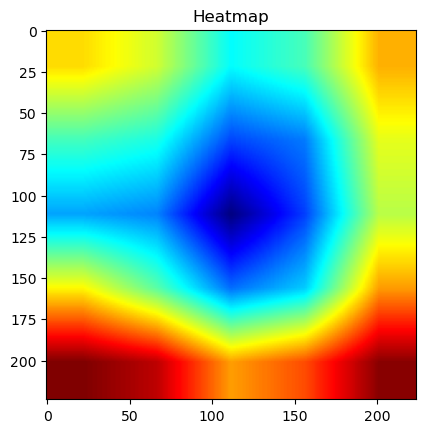

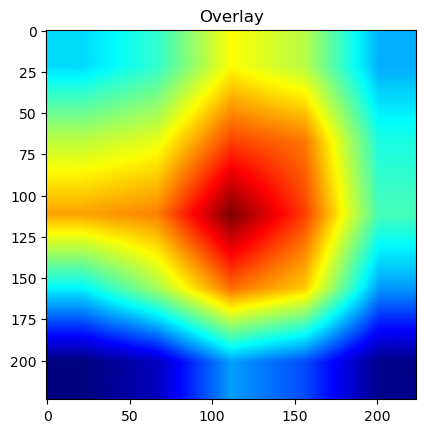

In [52]:
import matplotlib.pyplot as plt

# Convert overlaid_image to uint8 data type and convert BGR to RGB
overlaid_image_rgb = cv2.convertScaleAbs(overlaid_image, alpha=(255.0/overlaid_image.max()))
overlaid_image_rgb = cv2.cvtColor(overlaid_image_rgb, cv2.COLOR_BGR2RGB)

# Display the heatmap and overlaid_image using Matplotlib
plt.imshow(heatmap, cmap='hot')  # Assuming heatmap is a grayscale image
plt.title("Heatmap")
plt.show()

plt.imshow(overlaid_image_rgb)
plt.title("Overlay")
plt.show()
